In [2]:
import nltk
import PyPDF2
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
from textblob import TextBlob
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

# Load Lexico v2.0 dictionary
lexico = pd.read_csv('C:\\Users\\PICHAU\\Documents\\ArthurAnzai\\lexiconPT\\data-raw\\lexico_v2.1txt', sep=',', header=None)
lexico.columns = ['word', 'polarity', 'sentiment']

# Load OPLexico v3.0 dictionary
oplexico = pd.read_csv('C:\\Users\\PICHAU\\Documents\\ArthurAnzai\\lexiconPT\\data-raw\\oplexicon_v3.0\\lexico_v3.0.txt', sep=',', header=None)
oplexico.columns = ['word', 'polarity', 'sentiment','classification']

# Load SentiLex-flex-PT02 dictionary

file = open('C:\\Users\\PICHAU\\Documents\\ArthurAnzai\\lexiconPT\\data-raw\\SentiLex-lem-PT02.txt', 'r', encoding='utf-8')

lines = []

for line in file:
    lines.append(line.strip('.'))  
file.close()
data = {'word':[],'PoS': [],  'polarity_target': [], 'polarity': [], 'polarity_classification': []}
for line in lines:
    columns = re.split(r'[.;]', line)
    data['word'].append(columns[0])
    data['PoS'].append(columns[1].split('=')[1])
    #data['FLEX'].append(columns[2].split('=')[1])
    data['polarity_target'].append(columns[2].split('=')[1])
    data['polarity'].append(columns[3].split('=')[1])
    data['polarity_classification'].append(columns[4].split('=')[1])
   
df = pd.DataFrame(data)
df['polarity'] = pd.to_numeric(df['polarity'])
senti_lex = df

# Load Vader sentiment analyzer
vader = SentimentIntensityAnalyzer()
# Remover Stop Words
def remove_stop_words(text):
    stop_words = set(stopwords.words('portuguese'))
    tokens = text.split()
    filtered_text = [word for word in tokens if not word in stop_words]
    return ' '.join(filtered_text)

# Define sentiment score functions
def lexico_score(sentence):
    tokens = nltk.word_tokenize(sentence.lower())
    score = 0
    for token in tokens:
        if token in lexico['word'].values:
            score += lexico.loc[lexico['word'] == token, 'sentiment'].values[0]
    return score


def oplexicon_score(sentence):
    tokens = nltk.word_tokenize(sentence.lower())
    score = 0
    for token in tokens:
        if token in oplexico['word'].values:
            score += oplexico.loc[oplexico['word'] == token, 'sentiment'].values[0]
    return score


def sentilex_score(sentence):
    tokens = nltk.word_tokenize(sentence.lower())
    score = 0
    for token in tokens:
        if token in senti_lex['word'].values:
            score += senti_lex.loc[senti_lex['word'] == token, 'polarity'].values[0]
    return score

def sentiment_analysis_overall(pdf):
    
    pdf_file = open(pdf, 'rb')
    pdf_reader = PyPDF2.PdfFileReader(pdf_file)

    # Tokenize PDF text into sentences
    text = ''
    for i in range(pdf_reader.getNumPages()):
        page = pdf_reader.getPage(i)
        text += page.extractText()
    text = text.lower() # convert to lowercase
    clean_text = re.sub(r'[^\w\s]', '', text).replace('\n', '')
    clean_text = remove_stop_words(clean_text)
    sentences = sent_tokenize(clean_text)
    
    # Compute sentiment scores for each sentence
    results = []
    for i, sentence in enumerate(sentences):
        
        # First, try to use the oplexicon_score 
        score = oplexicon_score(sentence)
        source = 'oplexicon_score'

        # If the score is 0, try to use the lexico_score
        if score == 0:
            score =  lexico_score(sentence)
            source = 'lexico_score'

        # If the score is 0, try to use the sentilex_score
        if score == 0:
            score = sentilex_score(sentence)
            source = 'sentilex_score'

        # If the score is 0, use the Vader score
        if score == 0:
            score = vader.polarity_scores(sentence)['compound']
            source = 'vader_score'

        # If the score is still 0, use the TextBlob score
        if score == 0:
            score = TextBlob(sentence).sentiment.polarity
            source = 'textblob_score'

        result = {
            'sentence': i,
            'score': score,
            'source': source,
            'text': sentence,
        }

        results.append(result)

    # Convert results to a pandas DataFrame
    results_df = pd.DataFrame(results)
    results_df

    # Compute overall sentiment score
    overall_score = results_df['score'].mean()
    overall_score
    #print(f"Overall Sentiment Score: {overall_score}")
    return overall_score

def sentiment_analysis(pdf):
    # Read in PDF file
    pdf_file = open(pdf, 'rb')
    pdf_reader = PyPDF2.PdfFileReader(pdf_file)

    # Tokenize PDF text into sentences

    text = ''
    for i in range(pdf_reader.getNumPages()):
        page = pdf_reader.getPage(i)
        text += page.extractText()
    text = text.lower() # convert to lowercase
    clean_text = re.sub(r'[^\w\s]', '', text).replace('\n', '')
    clean_text = remove_stop_words(clean_text)
    sentences = sent_tokenize(clean_text)

    # Compute sentiment scores for each sentence
    lexico_scores = [lexico_score(sentence) for sentence in sentences]
    sentilex_scores = [sentilex_score(sentence) for sentence in sentences]
    oplexicon_scores = [oplexicon_score(sentence) for sentence in sentences]
    vader_scores = [vader.polarity_scores(sentence)['compound'] for sentence in sentences]
    textblob_scores = [TextBlob(sentence).sentiment.polarity for sentence in sentences]


    results = []
    # Compare the scores
    for i in range(len(sentences)):
        result = {
                'sentence': i,
                'vader_score': vader_scores[i],
                'lexico_score': lexico_scores[i],
                'sentilex_score': sentilex_scores[i],
                'oplexicon_score': oplexicon_scores[i],
                'textblob_score': textblob_scores[i]
            }
        results.append(result)

    # Compute total sentiment scores for the document
    lexico_total = sum(lexico_scores)
    sentilex_total = sum(sentilex_scores)
    oplexicon_total = sum(oplexicon_scores)
    vader_total = sum(vader_scores)
    textblob_total = sum(textblob_scores)

    # Compute average sentiment scores for the document
    num_sentences = len(sentences)
    lexico_avg = lexico_total / num_sentences
    sentilex_avg = sentilex_total / num_sentences
    oplexicon_avg = oplexicon_total / num_sentences
    vader_avg = vader_total / num_sentences
    textblob_avg = textblob_total / num_sentences
    
    overall_score = sentiment_analysis_overall(pdf)
    
    # Print the final results
    #print("Final Results:")
    #print(f"Lexico Avg Score: {lexico_avg}")
    #print(f"Sentilex Avg Score: {sentilex_avg}")
    #print(f"OPLexicon Avg Score: {oplexicon_avg}")
    #print(f"Vader Avg Score: {vader_avg}")
    #print(f"TextBlob Avg Score: {textblob_avg}")
    #print(f"Overall Sentiment Score: {overall_score}")

   # Create a dictionary with the total scores
    results = {
        'file_name': pdf,
        'lexico_total': lexico_total,
        'sentilex_total': sentilex_total,
        'oplexicon_total': oplexicon_total,
        'vader_total': vader_total,
        'textblob_total': textblob_total,
        'Lexico Avg Score': lexico_avg,
        'Sentilex Avg Score': sentilex_avg,
        'OPLexicon Avg Score': oplexicon_avg,
        'Vader Avg Score': vader_avg,
        'TextBlob Avg Score': textblob_avg,
        'Overall Sentiment Score': overall_score
    }

    # Create a DataFrame with the results dictionary
    df = pd.DataFrame([results])

    # Print the final results
    #print("Final Results:")
    #print(df)

    return results

def sentiment_analysis_sentence(pdf):
    # Read in PDF file
    pdf_file = open(pdf, 'rb')
    pdf_reader = PyPDF2.PdfFileReader(pdf_file)

    # Tokenize PDF text into sentences

    text = ''
    for i in range(pdf_reader.getNumPages()):
        page = pdf_reader.getPage(i)
        text += page.extractText()
        
    text = text.lower() # convert to lowercase
    clean_text = re.sub(r'[^\w\s]', '', text).replace('\n', '')
    clean_text = remove_stop_words(clean_text)
    sentences = sent_tokenize(clean_text)
    
   

    # Compute sentiment scores for each sentence
    lexico_scores = [lexico_score(sentence) for sentence in sentences]
    sentilex_scores = [sentilex_score(sentence) for sentence in sentences]
    oplexicon_scores = [oplexicon_score(sentence) for sentence in sentences]
    vader_scores = [vader.polarity_scores(sentence)['compound'] for sentence in sentences]
    textblob_scores = [TextBlob(sentence).sentiment.polarity for sentence in sentences]


    results = []
    # Compare the scores
    for i in range(len(sentences)):
        result = {
                'pdf': pdf,
                'sentence_ID': i,
                'sentence':sentences[i],
                'vader_score': vader_scores[i],
                'lexico_score': lexico_scores[i],
                'sentilex_score': sentilex_scores[i],
                'oplexicon_score': oplexicon_scores[i],
                'textblob_score': textblob_scores[i]
            }
        results.append(result)

    # Create a DataFrame with the results dictionary
    df = pd.DataFrame([results])

    # Print the final results
    #print("Final Results:")
    #print(df)

    return results

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PICHAU\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
lista_UNIPAR = [ 'UNIPAR_Release de Resultados 1T22.pdf'
,'UNIPAR_Release de Resultados 2T22.pdf'
,'UNIPAR_Release de Resultados 3T22.pdf'
,'UNIPAR_Release de Resultados 1T21.pdf'
,'UNIPAR_Release de Resultados 2T21.pdf'
,'UNIPAR_Release de Resultados 3T21.pdf'
,'UNIPAR_Release de Resultados 4T21.pdf'
,'UNIPAR_Release de Resultados 1T20.pdf'
,'UNIPAR_Release de Resultados 2T20.pdf'
,'UNIPAR_Release de Resultados 3T20.pdf'
,'UNIPAR_Release de Resultados 4T20.pdf'
,'UNIPAR_Release de Resultados 1T19.pdf'
,'UNIPAR_Release de Resultados 2T19.pdf'
,'UNIPAR_Release de Resultados 3T19.pdf'
,'UNIPAR_Release de Resultados 4T19.pdf']

lista_copel = ['COPEL_Release de Resultados 1T19.pdf'
,'COPEL_Release de Resultados 2T19.pdf'
,'COPEL_Release de Resultados 3T19.pdf'
,'COPEL_Release de Resultados 4T19.pdf'
,'COPEL_Release de Resultados 1T20.pdf'
,'COPEL_Release de Resultados 2T20.pdf'
,'COPEL_Release de Resultados 3T20.pdf'
,'COPEL_Release de Resultados 4T20.pdf'
,'COPEL_Release de Resultados 1T21.pdf'
,'COPEL_Release de Resultados 2T21.pdf'
,'COPEL_Release de Resultados 3T21.pdf'
,'COPEL_Release de Resultados 4T21.pdf'
,'COPEL_Release de Resultados 1T22.pdf'
,'COPEL_Release de Resultados 2T22.pdf'
,'COPEL_Release de Resultados 3T22.pdf' ]


lista_VIVO = ['VIVO_Release de Resultados 1T19.pdf'
,'VIVO_Release de Resultados 2T19.pdf'
,'VIVO_Release de Resultados 3T19.pdf'
,'VIVO_Release de Resultados 4T19.pdf'
,'VIVO_Release de Resultados 1T20.pdf'
,'VIVO_Release de Resultados 2T20.pdf'
,'VIVO_Release de Resultados 3T20.pdf'
,'VIVO_Release de Resultados 4T20.pdf'
,'VIVO_Release de Resultados 1T21.pdf'
,'VIVO_Release de Resultados 2T21.pdf'
,'VIVO_Release de Resultados 3T21.pdf'
,'VIVO_Release de Resultados 4T21.pdf'
,'VIVO_Release de Resultados 1T22.pdf'
,'VIVO_Release de Resultados 2T22.pdf'
,'VIVO_Release de Resultados 3T22.pdf' ]


lista_TAESA = ['TAESA_Release de Resultados 1T19.pdf'
,'TAESA_Release de Resultados 2T19.pdf'
,'TAESA_Release de Resultados 3T19.pdf'
,'TAESA_Release de Resultados 4T19.pdf'
,'TAESA_Release de Resultados 1T20.pdf'
,'TAESA_Release de Resultados 2T20.pdf'
,'TAESA_Release de Resultados 3T20.pdf'
,'TAESA_Release de Resultados 4T20.pdf'
,'TAESA_Release de Resultados 1T21.pdf'
,'TAESA_Release de Resultados 2T21.pdf'
,'TAESA_Release de Resultados 3T21.pdf'
,'TAESA_Release de Resultados 4T21.pdf'
,'TAESA_Release de Resultados 1T22.pdf'
,'TAESA_Release de Resultados 2T22.pdf'
,'TAESA_Release de Resultados 3T22.pdf' ]


lista_ROMI = ['ROMI_Release de Resultados 1T19.pdf'
,'ROMI_Release de Resultados 2T19.pdf'
,'ROMI_Release de Resultados 3T19.pdf'
,'ROMI_Release de Resultados 4T19.pdf'
,'ROMI_Release de Resultados 1T20.pdf'
,'ROMI_Release de Resultados 2T20.pdf'
,'ROMI_Release de Resultados 3T20.pdf'
,'ROMI_Release de Resultados 4T20.pdf'
,'ROMI_Release de Resultados 1T21.pdf'
,'ROMI_Release de Resultados 2T21.pdf'
,'ROMI_Release de Resultados 3T21.pdf'
,'ROMI_Release de Resultados 4T21.pdf'
,'ROMI_Release de Resultados 1T22.pdf'
,'ROMI_Release de Resultados 2T22.pdf'
,'ROMI_Release de Resultados 3T22.pdf' ]



def run_sentiment_analysis(lista):
    total_lista = []
    for i in range(len(lista)):
        result = sentiment_analysis(lista[i])
        total_lista.append(result)
    return total_lista
    

In [3]:
def run_sentiment_analysis_sentence(lista):
    total_lista = []
    for i in range(len(lista)):
        result = sentiment_analysis_sentence(lista[i])
        total_lista.append(result)
    return total_lista

In [4]:
def verificar_lexico(bag_of_words, lexico):
    resultado = {}
    for palavra in bag_of_words:
        if palavra in lexico:
            resultado[palavra] = 1
        else:
            resultado[palavra] = 0
    return resultado


In [50]:
from collections import Counter


def evaluate_words_pdf(pdf):
    final_list = {}
    # Read in PDF file
    pdf_file = open(pdf, 'rb')
    pdf_reader = PyPDF2.PdfFileReader(pdf_file)

    # Extract text from PDF and preprocess it
    text = ''
    for i in range(pdf_reader.getNumPages()):
        page = pdf_reader.getPage(i)
        text += page.extractText()
    text = text.lower()
    clean_text = re.sub(r'[^\w\s]', '', text).replace('\n', '')
    clean_text = remove_stop_words(clean_text)

    # Convert text to dictionary of words and their counts
    word_counts = Counter(clean_text.split())

    # Evaluate words against dictionaries
    evaluated_words = evaluate_words(word_counts,pdf)
    
    return evaluated_words

def evaluate_words(word_counts,file_name):
    evaluated_words = []
    found_in_l = found_in_o = found_in_sl = found_in_v = found_in_t = 0 # Initialize all found_in variables to 0
    for word, count in word_counts.items():
        word_set_l = set(lexico['word'].values)
        word_set_o = set(oplexico['word'].values)
        word_set_sl = set(senti_lex['word'].values)
        

        if word in word_set_l:
            found_in_l = 1 
            found_in_o = found_in_sl = found_in_v = found_in_t = 0
            evaluated_words.append({'file_name':file_name
            ,'word': word
            ,'count': count
            ,'Found Lexico': found_in_l
            ,'Found OPLexico': found_in_o
            ,'Found senti_lex': found_in_sl
            ,'Found Vader': found_in_v
            ,'Found Text': found_in_t})

        if word in word_set_o:
            found_in_o = 1 
            found_in_l = found_in_sl = found_in_v = found_in_t = 0
            evaluated_words.append({'file_name':file_name
            ,'word': word
            ,'count': count
            ,'Found Lexico': found_in_l
            ,'Found OPLexico': found_in_o
            ,'Found senti_lex': found_in_sl
            ,'Found Vader': found_in_v
            ,'Found Text': found_in_t})

        if word in word_set_sl:
            found_in_sl = 1
            found_in_l = found_in_o = found_in_v = found_in_t = 0
            evaluated_words.append({'file_name':file_name
            ,'word': word
            ,'count': count
            ,'Found Lexico': found_in_l
            ,'Found OPLexico': found_in_o
            ,'Found senti_lex': found_in_sl
            ,'Found Vader': found_in_v
            ,'Found Text': found_in_t})

        if vader.polarity_scores(word)['compound'] != 0:
            found_in_v = 1
            found_in_l = found_in_o = found_in_sl = found_in_t = 0
            evaluated_words.append({'file_name':file_name
            ,'word': word
            ,'count': count
            ,'Found Lexico': found_in_l
            ,'Found OPLexico': found_in_o
            ,'Found senti_lex': found_in_sl
            ,'Found Vader': found_in_v
            ,'Found Text': found_in_t})

        if TextBlob(word).sentiment.polarity != 0:
            found_in_t = 1     
            found_in_l = found_in_o = found_in_sl = found_in_v = 0
            evaluated_words.append({'file_name':file_name
                    ,'word': word
                    ,'count': count
                    ,'Found Lexico': found_in_l
                    ,'Found OPLexico': found_in_o
                    ,'Found senti_lex': found_in_sl
                    ,'Found Vader': found_in_v
                    ,'Found Text': found_in_t})

        else:
            found_in_l = found_in_o = found_in_sl = found_in_v = found_in_t = 0 #'None'   
            evaluated_words.append({'file_name':file_name
                            ,'word': word
                            ,'count': count
                            ,'Found Lexico': found_in_l
                            ,'Found OPLexico': found_in_o
                            ,'Found senti_lex': found_in_sl
                            ,'Found Vader': found_in_v
                            ,'Found Text': found_in_t})

        
    return evaluated_words




In [15]:
aaaa = evaluate_words_pdf('TAESA_Release de Resultados 1T19.pdf')


NameError: name 'evaluated_words' is not defined

In [20]:
pdf = ('TAESA_Release de Resultados 1T19.pdf')

final_list = {}
# Read in PDF file
pdf_file = open(pdf, 'rb')
pdf_reader = PyPDF2.PdfFileReader(pdf_file)

# Extract text from PDF and preprocess it
text = ''
for i in range(pdf_reader.getNumPages()):
    page = pdf_reader.getPage(i)
    text += page.extractText()
text = text.lower()
clean_text = re.sub(r'[^\w\s]', '', text).replace('\n', '')
clean_text = remove_stop_words(clean_text)

# Convert text to dictionary of words and their counts
word_counts = Counter(clean_text.split())

# Evaluate words against dictionaries
essabosta2 = evaluate_words(word_counts,pdf)

essabosta2

[{'file_name': 'TAESA_Release de Resultados 1T19.pdf',
  'word': '1',
  'count': 54,
  'Found Lexico': 0,
  'Found OPLexico': 0,
  'Found senti_lex': 0,
  'Found Vader': 0,
  'Found Text': 0},
 {'file_name': 'TAESA_Release de Resultados 1T19.pdf',
  'word': 'resultado',
  'count': 118,
  'Found Lexico': 0,
  'Found OPLexico': 0,
  'Found senti_lex': 0,
  'Found Vader': 0,
  'Found Text': 0},
 {'file_name': 'TAESA_Release de Resultados 1T19.pdf',
  'word': '1º',
  'count': 52,
  'Found Lexico': 0,
  'Found OPLexico': 0,
  'Found senti_lex': 0,
  'Found Vader': 0,
  'Found Text': 0},
 {'file_name': 'TAESA_Release de Resultados 1T19.pdf',
  'word': 'trimestre',
  'count': 58,
  'Found Lexico': 0,
  'Found OPLexico': 0,
  'Found senti_lex': 0,
  'Found Vader': 0,
  'Found Text': 0},
 {'file_name': 'TAESA_Release de Resultados 1T19.pdf',
  'word': '2019',
  'count': 95,
  'Found Lexico': 0,
  'Found OPLexico': 0,
  'Found senti_lex': 0,
  'Found Vader': 0,
  'Found Text': 0},
 {'file_name':

In [42]:
evaluated_words = []
found_in_l = found_in_o = found_in_sl = found_in_v = found_in_t = 0 # Initialize all found_in variables to 0
for word, count in word_counts.items():
    word_set_l = set(lexico['word'].values)
    word_set_o = set(oplexico['word'].values)
    word_set_sl = set(senti_lex['word'].values)

    if word in word_set_l:
        found_in_l = 1 
        found_in_o = found_in_sl = found_in_v = found_in_t = 0
        evaluated_words.append({'file_name':'coco'
        ,'word': word
        ,'count': count
        ,'Found Lexico': found_in_l
        ,'Found OPLexico': found_in_o
        ,'Found senti_lex': found_in_sl
        ,'Found Vader': found_in_v
        ,'Found Text': found_in_t})
        
    if word in word_set_o:
        found_in_o = 1 
        found_in_l = found_in_sl = found_in_v = found_in_t = 0
        evaluated_words.append({'file_name':'coco'
        ,'word': word
        ,'count': count
        ,'Found Lexico': found_in_l
        ,'Found OPLexico': found_in_o
        ,'Found senti_lex': found_in_sl
        ,'Found Vader': found_in_v
        ,'Found Text': found_in_t})
        
    if word in word_set_sl:
        found_in_sl = 1
        found_in_l = found_in_o = found_in_v = found_in_t = 0
        evaluated_words.append({'file_name':'coco'
        ,'word': word
        ,'count': count
        ,'Found Lexico': found_in_l
        ,'Found OPLexico': found_in_o
        ,'Found senti_lex': found_in_sl
        ,'Found Vader': found_in_v
        ,'Found Text': found_in_t})
        
    if vader.polarity_scores(word)['compound'] != 0:
        found_in_v = 1
        found_in_l = found_in_o = found_in_sl = found_in_t = 0
        evaluated_words.append({'file_name':'coco'
        ,'word': word
        ,'count': count
        ,'Found Lexico': found_in_l
        ,'Found OPLexico': found_in_o
        ,'Found senti_lex': found_in_sl
        ,'Found Vader': found_in_v
        ,'Found Text': found_in_t})
        
    if TextBlob(word).sentiment.polarity != 0:
        found_in_t = 1     
        found_in_l = found_in_o = found_in_sl = found_in_v = 0
        evaluated_words.append({'file_name':'coco'
                ,'word': word
                ,'count': count
                ,'Found Lexico': found_in_l
                ,'Found OPLexico': found_in_o
                ,'Found senti_lex': found_in_sl
                ,'Found Vader': found_in_v
                ,'Found Text': found_in_t})
        
    else:
        found_in_l = found_in_o = found_in_sl = found_in_v = found_in_t = 0 #'None'   
        evaluated_words.append({'file_name':'coco'
                        ,'word': word
                        ,'count': count
                        ,'Found Lexico': found_in_l
                        ,'Found OPLexico': found_in_o
                        ,'Found senti_lex': found_in_sl
                        ,'Found Vader': found_in_v
                        ,'Found Text': found_in_t})



evaluated_words       

[{'file_name': 'coco',
  'word': '1',
  'count': 54,
  'Found Lexico': 0,
  'Found OPLexico': 0,
  'Found senti_lex': 0,
  'Found Vader': 0,
  'Found Text': 0},
 {'file_name': 'coco',
  'word': 'resultado',
  'count': 118,
  'Found Lexico': 0,
  'Found OPLexico': 0,
  'Found senti_lex': 0,
  'Found Vader': 0,
  'Found Text': 0},
 {'file_name': 'coco',
  'word': '1º',
  'count': 52,
  'Found Lexico': 0,
  'Found OPLexico': 0,
  'Found senti_lex': 0,
  'Found Vader': 0,
  'Found Text': 0},
 {'file_name': 'coco',
  'word': 'trimestre',
  'count': 58,
  'Found Lexico': 0,
  'Found OPLexico': 0,
  'Found senti_lex': 0,
  'Found Vader': 0,
  'Found Text': 0},
 {'file_name': 'coco',
  'word': '2019',
  'count': 95,
  'Found Lexico': 0,
  'Found OPLexico': 0,
  'Found senti_lex': 0,
  'Found Vader': 0,
  'Found Text': 0},
 {'file_name': 'coco',
  'word': 'rio',
  'count': 4,
  'Found Lexico': 0,
  'Found OPLexico': 0,
  'Found senti_lex': 0,
  'Found Vader': 0,
  'Found Text': 0},
 {'file_name

In [22]:
essabosta2 = pd.DataFrame(essabosta2)
#essabosta.to_csv('testemeudeus.csv', encoding = 'utf-8')

In [23]:
word_set_l = set(lexico['word'].values)
for i in essabosta2['word']:
     if i in word_set_l:
            print(i)

maiores
primeiro
preparadas
práticas
definidas
expedidas
adotar
partir
retrospectivo
modificado
explicado
apresentar
intermediárias
referentes
realizados
respectivo
mercantil
observadas
importante
ressaltar
passivo
efetuar
ativo
direito
usar
seguir
apresentado
preparado
vigente
registrados
imobilizado
impactos
fiscais
ir
temporárias
oriundas
apresentadas
apresentados
mencionar
facilitar
associados
definidos
controladas
conjunto
feita
diretor
gerente
nova
econômico
impacto
impostos
capital
próprio
subsidiárias
importantes
par
positiva
ter
queda
maior
marcado
iniciadas
antecipar
buscar
melhores
formal
deter
ativos
econômica
pedido
representativas
total
concluir
adicionar
novas
concentrado
relevante
positivo
destacar
pagos
adicionais
referente
social
ajustado
levantadas
comprometer
especial
principais
detidas
segregadas
mariana
real
nomeado
grande
assinado
fantasia
dado
consistente
média
indicador
disponível
dividido
contida
instável
curto
melhor
maneira
entender
analisar
pequeno
bucha
bo

In [51]:
kk = []
for i in lista_TAESA:
    print(i)
    a = evaluate_words_pdf(i)
    kk +=  a
    #kk.append(a)
    
kk = pd.DataFrame(kk)


kk2 = []
for i in lista_copel:
    print(i)
    a = evaluate_words_pdf(i)
    kk2 +=  a
    #kk.append(a)
    
kk2 = pd.DataFrame(kk2)


kk3 = []
for i in lista_VIVO:
    print(i)
    a = evaluate_words_pdf(i)
    kk3 +=  a
    #kk.append(a)
    
kk3 = pd.DataFrame(kk3)

kk4 = []
for i in lista_ROMI:
    print(i)
    a = evaluate_words_pdf(i)
    kk4 +=  a
    #kk.append(a)
    
kk4 = pd.DataFrame(kk4)

kk5 = []
for i in lista_UNIPAR:
    print(i)
    a = evaluate_words_pdf(i)
    kk5 +=  a
    #kk.append(a)
    
kk5 = pd.DataFrame(kk5)


kk.to_csv('TAESA_PALAVRAS.csv', encoding="utf-8")
kk2.to_csv('COPEL_PALAVRAS.csv', encoding="utf-8")
kk3.to_csv('VIVO_PALAVRAS.csv', encoding="utf-8")
kk4.to_csv('ROMI_PALAVRAS.csv', encoding="utf-8")
kk5.to_csv('UNIPAR_PALAVRAS.csv', encoding="utf-8")


TAESA_Release de Resultados 1T19.pdf
TAESA_Release de Resultados 2T19.pdf
TAESA_Release de Resultados 3T19.pdf
TAESA_Release de Resultados 4T19.pdf
TAESA_Release de Resultados 1T20.pdf
TAESA_Release de Resultados 2T20.pdf
TAESA_Release de Resultados 3T20.pdf
TAESA_Release de Resultados 4T20.pdf
TAESA_Release de Resultados 1T21.pdf
TAESA_Release de Resultados 2T21.pdf
TAESA_Release de Resultados 3T21.pdf
TAESA_Release de Resultados 4T21.pdf
TAESA_Release de Resultados 1T22.pdf
TAESA_Release de Resultados 2T22.pdf
TAESA_Release de Resultados 3T22.pdf


XRef object at 1217761 can not be read, some object may be missing


COPEL_Release de Resultados 1T19.pdf


XRef object at 1204462 can not be read, some object may be missing


COPEL_Release de Resultados 2T19.pdf
COPEL_Release de Resultados 3T19.pdf
COPEL_Release de Resultados 4T19.pdf
COPEL_Release de Resultados 1T20.pdf
COPEL_Release de Resultados 2T20.pdf
COPEL_Release de Resultados 3T20.pdf
COPEL_Release de Resultados 4T20.pdf
COPEL_Release de Resultados 1T21.pdf
COPEL_Release de Resultados 2T21.pdf
COPEL_Release de Resultados 3T21.pdf
COPEL_Release de Resultados 4T21.pdf
COPEL_Release de Resultados 1T22.pdf
COPEL_Release de Resultados 2T22.pdf
COPEL_Release de Resultados 3T22.pdf
VIVO_Release de Resultados 1T19.pdf
VIVO_Release de Resultados 2T19.pdf


Xref table not zero-indexed. ID numbers for objects will be corrected.


VIVO_Release de Resultados 3T19.pdf
VIVO_Release de Resultados 4T19.pdf


Superfluous whitespace found in object header b'1' b'0'
Superfluous whitespace found in object header b'2' b'0'
Superfluous whitespace found in object header b'3' b'0'
Superfluous whitespace found in object header b'107' b'0'
Superfluous whitespace found in object header b'127' b'0'
Superfluous whitespace found in object header b'141' b'0'
Superfluous whitespace found in object header b'144' b'0'
Superfluous whitespace found in object header b'147' b'0'
Superfluous whitespace found in object header b'150' b'0'
Superfluous whitespace found in object header b'155' b'0'
Superfluous whitespace found in object header b'158' b'0'
Superfluous whitespace found in object header b'161' b'0'
Superfluous whitespace found in object header b'172' b'0'
Superfluous whitespace found in object header b'178' b'0'
Superfluous whitespace found in object header b'186' b'0'
Superfluous whitespace found in object header b'189' b'0'
Superfluous whitespace found in object header b'192' b'0'
Superfluous whitespa

VIVO_Release de Resultados 1T20.pdf


Superfluous whitespace found in object header b'108' b'0'
Superfluous whitespace found in object header b'140' b'0'
Superfluous whitespace found in object header b'135' b'0'
Superfluous whitespace found in object header b'134' b'0'
Superfluous whitespace found in object header b'133' b'0'
Superfluous whitespace found in object header b'139' b'0'
Superfluous whitespace found in object header b'143' b'0'
Superfluous whitespace found in object header b'142' b'0'
Superfluous whitespace found in object header b'146' b'0'
Superfluous whitespace found in object header b'145' b'0'
Superfluous whitespace found in object header b'149' b'0'
Superfluous whitespace found in object header b'148' b'0'
Superfluous whitespace found in object header b'154' b'0'
Superfluous whitespace found in object header b'153' b'0'
Superfluous whitespace found in object header b'157' b'0'
Superfluous whitespace found in object header b'156' b'0'
Superfluous whitespace found in object header b'160' b'0'
Superfluous wh

VIVO_Release de Resultados 2T20.pdf
VIVO_Release de Resultados 3T20.pdf


Xref table not zero-indexed. ID numbers for objects will be corrected.


VIVO_Release de Resultados 4T20.pdf
VIVO_Release de Resultados 1T21.pdf
VIVO_Release de Resultados 2T21.pdf
VIVO_Release de Resultados 3T21.pdf
VIVO_Release de Resultados 4T21.pdf


Xref table not zero-indexed. ID numbers for objects will be corrected.


VIVO_Release de Resultados 1T22.pdf
VIVO_Release de Resultados 2T22.pdf
VIVO_Release de Resultados 3T22.pdf
ROMI_Release de Resultados 1T19.pdf
ROMI_Release de Resultados 2T19.pdf
ROMI_Release de Resultados 3T19.pdf
ROMI_Release de Resultados 4T19.pdf
ROMI_Release de Resultados 1T20.pdf
ROMI_Release de Resultados 2T20.pdf
ROMI_Release de Resultados 3T20.pdf
ROMI_Release de Resultados 4T20.pdf
ROMI_Release de Resultados 1T21.pdf
ROMI_Release de Resultados 2T21.pdf
ROMI_Release de Resultados 3T21.pdf
ROMI_Release de Resultados 4T21.pdf
ROMI_Release de Resultados 1T22.pdf
ROMI_Release de Resultados 2T22.pdf
ROMI_Release de Resultados 3T22.pdf
UNIPAR_Release de Resultados 1T22.pdf
UNIPAR_Release de Resultados 2T22.pdf
UNIPAR_Release de Resultados 3T22.pdf
UNIPAR_Release de Resultados 1T21.pdf
UNIPAR_Release de Resultados 2T21.pdf
UNIPAR_Release de Resultados 3T21.pdf
UNIPAR_Release de Resultados 4T21.pdf
UNIPAR_Release de Resultados 1T20.pdf
UNIPAR_Release de Resultados 2T20.pdf
UNIPAR_Rel

In [52]:
import pandas as pd

# concatenate dataframes kk, kk2, kk3, kk4, and kk5
result = pd.concat([kk, kk2, kk3, kk4, kk5], ignore_index=True)
result

,file_name,word,count,Found Lexico,Found OPLexico,Found senti_lex,Found Vader,Found Text
0,TAESA_Release de Resultados 1T19.pdf,1,54,0,0,0,0,0
1,TAESA_Release de Resultados 1T19.pdf,resultado,118,0,0,0,0,0
2,TAESA_Release de Resultados 1T19.pdf,1º,52,0,0,0,0,0
3,TAESA_Release de Resultados 1T19.pdf,trimestre,58,0,0,0,0,0
4,TAESA_Release de Resultados 1T19.pdf,2019,95,0,0,0,0,0
...,...,...,...,...,...,...,...,...
277799,UNIPAR_Release de Resultados 4T19.pdf,044x,1,0,0,0,0,0
277800,UNIPAR_Release de Resultados 4T19.pdf,264x,1,0,0,0,0,0
277801,UNIPAR_Release de Resultados 4T19.pdf,aplicável,1,0,0,0,0,0
277802,UNIPAR_Release de Resultados 4T19.pdf,ebi,1,0,0,0,0,0


In [55]:
grouped = result.groupby('file_name').agg({'count': 'count', 'Found Lexico': 'sum', 'Found OPLexico': 'sum', 'Found senti_lex': 'sum', 'Found Vader': 'sum', 'Found Text': 'sum'})
grouped.to_csv('arquivo_palavras_encontradas.csv')

In [ ]:
a = run_sentiment_analysis(lista_UNIPAR)
b = run_sentiment_analysis(lista_copel)
c = run_sentiment_analysis(lista_VIVO)
d = run_sentiment_analysis(lista_TAESA)
e = run_sentiment_analysis(lista_ROMI)

In [ ]:
df_save = pd.DataFrame(a)
df_save.to_csv('UNIPAR_Result.csv')

df_saveb = pd.DataFrame(b)
df_saveb.to_csv('COPEL_Result.csv')

df_savec = pd.DataFrame(c)
df_savec.to_csv('VIVO_Result.csv')

df_saved = pd.DataFrame(d)
df_saved.to_csv('TAESA_Result.csv')

df_savee = pd.DataFrame(e)
df_savee.to_csv('ROMI_Result.csv')

In [ ]:
df_save['Overall Sentiment Score']

In [ ]:
a_s = run_sentiment_analysis_sentence(lista_UNIPAR)
b_s = run_sentiment_analysis_sentence(lista_copel)

c_s = run_sentiment_analysis_sentence(lista_VIVO)
d_s = run_sentiment_analysis_sentence(lista_TAESA)

e_s = run_sentiment_analysis_sentence(lista_ROMI)

# The original list
list_of_lists = a_s
# Flatten the list of lists into a single list
flat_list = [item for sublist in list_of_lists for item in sublist]
# Create a dataframe
df_save = pd.DataFrame(flat_list)
df_save.to_csv('UNIPAR_Result_sentence.csv')

# The original list
list_of_lists = b_s
# Flatten the list of lists into a single list
flat_listb = [item for sublist in list_of_lists for item in sublist]
# Create a dataframe
df_saveb = pd.DataFrame(flat_listb)
df_saveb.to_csv('COPEL_Result_sentence.csv')


# The original list
list_of_lists = c_s
# Flatten the list of lists into a single list
flat_listc = [item for sublist in list_of_lists for item in sublist]
# Create a dataframe
df_savec = pd.DataFrame(flat_listc)
df_savec.to_csv('VIVO_Result_sentence.csv')

# The original list
list_of_lists = d_s
# Flatten the list of lists into a single list
flat_listd = [item for sublist in list_of_lists for item in sublist]
# Create a dataframe
df_saved = pd.DataFrame(flat_listd)
df_saved.to_csv('TAESA_Result_sentence.csv')

# The original list
list_of_lists = e_s
# Flatten the list of lists into a single list
flat_liste = [item for sublist in list_of_lists for item in sublist]
# Create a dataframe
df_savee = pd.DataFrame(flat_liste)
df_savee.to_csv('ROMI_Result_sentence.csv')

In [3]:
a = pd.read_csv('C:\\Users\\PICHAU\\Documents\\ArthurAnzai\\TCC\\UNIPAR_Result.csv', sep=',')
b = pd.read_csv('C:\\Users\\PICHAU\\Documents\\ArthurAnzai\\TCC\\COPEL_Result.csv', sep=',')
c = pd.read_csv('C:\\Users\\PICHAU\\Documents\\ArthurAnzai\\TCC\\VIVO_Result.csv', sep=',')
d = pd.read_csv('C:\\Users\\PICHAU\\Documents\\ArthurAnzai\\TCC\\TAESA_Result.csv', sep=',')
e = pd.read_csv('C:\\Users\\PICHAU\\Documents\\ArthurAnzai\\TCC\\ROMI_Result.csv', sep=',')


In [4]:
a_s = pd.read_csv('C:\\Users\\PICHAU\\Documents\\ArthurAnzai\\TCC\\UNIPAR_Result_sentence.csv', sep=',')
b_s = pd.read_csv('C:\\Users\\PICHAU\\Documents\\ArthurAnzai\\TCC\\COPEL_Result_sentence.csv', sep=',')
c_s = pd.read_csv('C:\\Users\\PICHAU\\Documents\\ArthurAnzai\\TCC\\VIVO_Result_sentence.csv', sep=',')
d_s = pd.read_csv('C:\\Users\\PICHAU\\Documents\\ArthurAnzai\\TCC\\TAESA_Result_sentence.csv', sep=',')
e_s = pd.read_csv('C:\\Users\\PICHAU\\Documents\\ArthurAnzai\\TCC\\ROMI_Result_sentence.csv', sep=',')

In [ ]:
a_s = run_sentiment_analysis_sentence(lista_UNIPAR)

In [ ]:
a_s

In [5]:
#lista_final =a + b + c + d + e
lista_final = pd.concat([a, b,c,d,e])
lista_final_s = pd.concat([a_s, b_s,c_s,d_s,e_s])

In [6]:
data_frame = pd.DataFrame(lista_final)
#data_frame.to_csv('lista_final.xlsx')
data_frame

,Unnamed: 0,file_name,lexico_total,sentilex_total,oplexicon_total,vader_total,textblob_total,Lexico Avg Score,Sentilex Avg Score,OPLexicon Avg Score,Vader Avg Score,TextBlob Avg Score,Overall Sentiment Score
0,0,UNIPAR_Release de Resultados 1T22.pdf,-42,15,-51,0.9136,0.097799,-42.0,15.0,-51.0,0.9136,0.097799,-51.0
1,1,UNIPAR_Release de Resultados 2T22.pdf,-11,31,-31,0.9967,0.201244,-11.0,31.0,-31.0,0.9967,0.201244,-31.0
2,2,UNIPAR_Release de Resultados 3T22.pdf,-25,34,-27,0.9858,0.204333,-25.0,34.0,-27.0,0.9858,0.204333,-27.0
3,3,UNIPAR_Release de Resultados 1T21.pdf,-23,18,-41,0.9896,0.197222,-23.0,18.0,-41.0,0.9896,0.197222,-41.0
4,4,UNIPAR_Release de Resultados 2T21.pdf,-34,44,-46,0.9914,0.145833,-34.0,44.0,-46.0,0.9914,0.145833,-46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,10,ROMI_Release de Resultados 3T21.pdf,-34,16,-54,-0.9643,0.044309,-34.0,16.0,-54.0,-0.9643,0.044309,-54.0
11,11,ROMI_Release de Resultados 4T21.pdf,-52,9,-72,-0.9758,0.046354,-52.0,9.0,-72.0,-0.9758,0.046354,-72.0
12,12,ROMI_Release de Resultados 1T22.pdf,-9,13,-23,0.8658,0.029630,-9.0,13.0,-23.0,0.8658,0.029630,-23.0
13,13,ROMI_Release de Resultados 2T22.pdf,-26,9,-42,0.9666,0.028455,-26.0,9.0,-42.0,0.9666,0.028455,-42.0


In [7]:
data_frame_s = pd.DataFrame(lista_final_s)
data_frame_s

,Unnamed: 0,pdf,sentence_ID,sentence,vader_score,lexico_score,sentilex_score,oplexicon_score,textblob_score
0,0,UNIPAR_Release de Resultados 1T22.pdf,0,divulgação resultados 1t22 unipar líder produç...,0.9136,-42,15,-51,0.097799
1,1,UNIPAR_Release de Resultados 2T22.pdf,0,divulgação resultados 2t22 unipar líder produç...,0.9967,-11,31,-31,0.201244
2,2,UNIPAR_Release de Resultados 3T22.pdf,0,1 release resultados 3t22 release resultados 3...,0.9858,-25,34,-27,0.204333
3,3,UNIPAR_Release de Resultados 1T21.pdf,0,divulgação resultados 1t21 unipar carbocloro s...,0.9896,-23,18,-41,0.197222
4,4,UNIPAR_Release de Resultados 2T21.pdf,0,divulgação resultados 2t21 unipar carbocloro s...,0.9914,-34,44,-46,0.145833
...,...,...,...,...,...,...,...,...,...
10,10,ROMI_Release de Resultados 3T21.pdf,0,1 release resultados 3º trimestre 2021 release...,-0.9643,-34,16,-54,0.044309
11,11,ROMI_Release de Resultados 4T21.pdf,0,1 release resultados 4º trimestre 2021 release...,-0.9758,-52,9,-72,0.046354
12,12,ROMI_Release de Resultados 1T22.pdf,0,1 release resultados 1º trimestre 2022 release...,0.8658,-9,13,-23,0.029630
13,13,ROMI_Release de Resultados 2T22.pdf,0,1 release resultados 2º trimestre 2022 release...,0.9666,-26,9,-42,0.028455


In [8]:
#data_frame = pd.DataFrame(c)
data_frame['Fiscal_Quarter'] = data_frame['file_name'].str.extract('(\d[Q|T]\d{2})')
data_frame['Empresa'] = data_frame['file_name'].str.extract('^([^_]*)')
data_frame

,Unnamed: 0,file_name,lexico_total,sentilex_total,oplexicon_total,vader_total,textblob_total,Lexico Avg Score,Sentilex Avg Score,OPLexicon Avg Score,Vader Avg Score,TextBlob Avg Score,Overall Sentiment Score,Fiscal_Quarter,Empresa
0,0,UNIPAR_Release de Resultados 1T22.pdf,-42,15,-51,0.9136,0.097799,-42.0,15.0,-51.0,0.9136,0.097799,-51.0,1T22,UNIPAR
1,1,UNIPAR_Release de Resultados 2T22.pdf,-11,31,-31,0.9967,0.201244,-11.0,31.0,-31.0,0.9967,0.201244,-31.0,2T22,UNIPAR
2,2,UNIPAR_Release de Resultados 3T22.pdf,-25,34,-27,0.9858,0.204333,-25.0,34.0,-27.0,0.9858,0.204333,-27.0,3T22,UNIPAR
3,3,UNIPAR_Release de Resultados 1T21.pdf,-23,18,-41,0.9896,0.197222,-23.0,18.0,-41.0,0.9896,0.197222,-41.0,1T21,UNIPAR
4,4,UNIPAR_Release de Resultados 2T21.pdf,-34,44,-46,0.9914,0.145833,-34.0,44.0,-46.0,0.9914,0.145833,-46.0,2T21,UNIPAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,10,ROMI_Release de Resultados 3T21.pdf,-34,16,-54,-0.9643,0.044309,-34.0,16.0,-54.0,-0.9643,0.044309,-54.0,3T21,ROMI
11,11,ROMI_Release de Resultados 4T21.pdf,-52,9,-72,-0.9758,0.046354,-52.0,9.0,-72.0,-0.9758,0.046354,-72.0,4T21,ROMI
12,12,ROMI_Release de Resultados 1T22.pdf,-9,13,-23,0.8658,0.029630,-9.0,13.0,-23.0,0.8658,0.029630,-23.0,1T22,ROMI
13,13,ROMI_Release de Resultados 2T22.pdf,-26,9,-42,0.9666,0.028455,-26.0,9.0,-42.0,0.9666,0.028455,-42.0,2T22,ROMI


In [10]:
dividendo = pd.read_excel('DIVIDENDOS_UNIPAR_FUNDAMENTOS.xlsx')
dividendo_ON = dividendo #dividendo.loc[dividendo['Tipo/Classe'] == 'ON']

# convert the date column to datetime format
dividendo_ON['Data'] = pd.to_datetime(dividendo_ON['Data'])

# extract the quarter and year from the date column and create a new column for the fiscal quarter and year
dividendo_ON['Quarter'] = dividendo_ON['Data'].dt.quarter-1
dividendo_ON['Year'] = dividendo_ON['Data'].dt.year
dividendo_ON['Fiscal_Quarter'] = dividendo_ON['Quarter'].astype(str) + 'T' + dividendo_ON['Year'].astype(str).str[-2:]



dividendo_ON_G = dividendo_ON.groupby(['Empresa','Fiscal_Quarter'])['Valor'].mean()
dividendo_ON_G
# exibir o resultado
#print(dividendo_ON_G)

Empresa  Fiscal_Quarter
COPEL    0T21              0.187056
         1T18              0.085900
         1T19              0.361600
         1T21              0.098567
         1T22              1.013050
                             ...   
VIVO     2T21              0.357300
         2T22              0.179800
         3T20              0.367233
         3T21              0.687250
         3T22              0.515450
Name: Valor, Length: 69, dtype: float64

In [11]:
dividendo_ON

,Empresa,Ação,Data,Valor,Tipo,Data Pagamento,qtd Ação,ano,mês,Tipo.1,Quarter,Year,Fiscal_Quarter
0,UNIPAR,UNIP5,2022-11-16,4.9887,DIVIDENDO,2022-11-29 00:00:00,1,2022.0,11.0,PN,3,2022,3T22
1,UNIPAR,UNIP5,2022-08-16,4.9841,DIVIDENDO,2022-08-26 00:00:00,1,2022.0,8.0,PN,2,2022,2T22
2,UNIPAR,UNIP5,2022-07-26,1.2460,DIVIDENDO,2022-08-05 00:00:00,1,2022.0,8.0,PN,2,2022,2T22
3,UNIPAR,UNIP5,2022-04-20,2.7352,DIVIDENDO,2022-05-04 00:00:00,1,2022.0,5.0,PN,1,2022,1T22
4,UNIPAR,UNIP5,2021-12-21,4.5898,DIVIDENDO,2021-12-30 00:00:00,1,2021.0,12.0,PN,3,2021,3T21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,ROMI,ROMI3,2019-09-16,0.4000,JRS CAP PROPRIO,2019-11-29 00:00:00,1,2019.0,11.0,ON,2,2019,2T19
238,ROMI,ROMI3,2019-03-29,0.4700,JRS CAP PROPRIO,2020-03-31 00:00:00,1,2020.0,3.0,ON,0,2019,0T19
239,ROMI,ROMI3,2018-09-17,0.2500,JRS CAP PROPRIO,2018-11-30 00:00:00,1,2018.0,11.0,ON,2,2018,2T18
240,ROMI,ROMI3,2018-04-23,0.4300,JRS CAP PROPRIO,2019-03-29 00:00:00,1,2019.0,3.0,ON,1,2018,1T18


In [12]:
df3 = pd.merge(data_frame, dividendo_ON_G, on=['Fiscal_Quarter','Empresa'], how='left')
df3
# Drop the rows that have missing values in column 'B'
df3 = df3.dropna(subset=['Valor'])
df3

,Unnamed: 0,file_name,lexico_total,sentilex_total,oplexicon_total,vader_total,textblob_total,Lexico Avg Score,Sentilex Avg Score,OPLexicon Avg Score,Vader Avg Score,TextBlob Avg Score,Overall Sentiment Score,Fiscal_Quarter,Empresa,Valor
0,0,UNIPAR_Release de Resultados 1T22.pdf,-42,15,-51,0.9136,0.097799,-42.0,15.0,-51.0,0.9136,0.097799,-51.0,1T22,UNIPAR,2.652300
1,1,UNIPAR_Release de Resultados 2T22.pdf,-11,31,-31,0.9967,0.201244,-11.0,31.0,-31.0,0.9967,0.201244,-31.0,2T22,UNIPAR,3.020667
2,2,UNIPAR_Release de Resultados 3T22.pdf,-25,34,-27,0.9858,0.204333,-25.0,34.0,-27.0,0.9858,0.204333,-27.0,3T22,UNIPAR,4.837533
3,3,UNIPAR_Release de Resultados 1T21.pdf,-23,18,-41,0.9896,0.197222,-23.0,18.0,-41.0,0.9896,0.197222,-41.0,1T21,UNIPAR,1.279000
4,4,UNIPAR_Release de Resultados 2T21.pdf,-34,44,-46,0.9914,0.145833,-34.0,44.0,-46.0,0.9914,0.145833,-46.0,2T21,UNIPAR,1.591367
5,5,UNIPAR_Release de Resultados 3T21.pdf,-19,43,-28,0.9969,0.182240,-19.0,43.0,-28.0,0.9969,0.182240,-28.0,3T21,UNIPAR,2.652278
7,7,UNIPAR_Release de Resultados 1T20.pdf,-19,13,-55,0.9823,0.142273,-19.0,13.0,-55.0,0.9823,0.142273,-55.0,1T20,UNIPAR,0.514000
9,9,UNIPAR_Release de Resultados 3T20.pdf,-11,53,-27,0.9961,0.241250,-11.0,53.0,-27.0,0.9961,0.241250,-27.0,3T20,UNIPAR,0.763633
11,11,UNIPAR_Release de Resultados 1T19.pdf,-38,13,-54,0.9792,-0.027778,-38.0,13.0,-54.0,0.9792,-0.027778,-54.0,1T19,UNIPAR,0.291900
15,0,COPEL_Release de Resultados 1T19.pdf,-48,230,-54,0.9871,0.048413,-48.0,230.0,-54.0,0.9871,0.048413,-54.0,1T19,COPEL,0.361600


In [13]:
df_tocsv = df3[['file_name','Fiscal_Quarter','Empresa','Overall Sentiment Score','Valor','Overall Sentiment Score_norm','Valor_norm']]
df_tocsv.to_csv('final_file.csv')


KeyError: "['Valor_norm', 'Overall Sentiment Score_norm'] not in index"

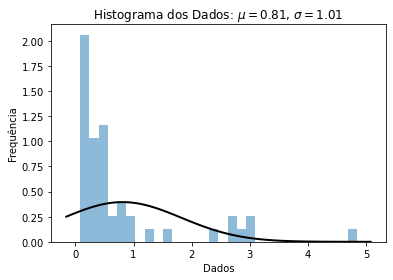

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Gerando dados aleatórios de uma distribuição normal
data = df3['Valor']

# Plotando um histograma dos dados
plt.hist(data, bins=30, density=True, alpha=0.5)

# Calculando a média e o desvio padrão dos dados
mu, std = norm.fit(data)

# Gerando uma curva normal com a média e desvio padrão calculados
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Configurando o gráfico
plt.xlabel('Dados')
plt.ylabel('Frequência')
plt.title(r'Histograma dos Dados: $\mu={:.2f}$, $\sigma={:.2f}$'.format(mu, std))


plt.savefig('Histogram_Valor.jpg')
# Mostrando o gráfico
plt.show()




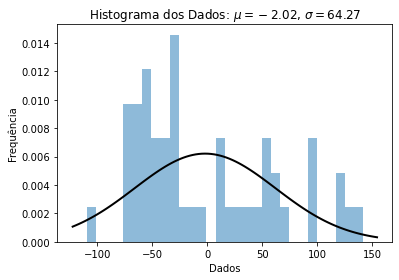

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Gerando dados aleatórios de uma distribuição normal
data = df3['Overall Sentiment Score']

# Plotando um histograma dos dados
plt.hist(data, bins=30, density=True, alpha=0.5)

# Calculando a média e o desvio padrão dos dados
mu, std = norm.fit(data)

# Gerando uma curva normal com a média e desvio padrão calculados
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Configurando o gráfico
plt.xlabel('Dados')
plt.ylabel('Frequência')
plt.title(r'Histograma dos Dados: $\mu={:.2f}$, $\sigma={:.2f}$'.format(mu, std))

plt.savefig('Histogram_Sentimento.jpg')
# Mostrando o gráfico
plt.show()



In [16]:
from scipy.stats import kstest, norm
import numpy as np
from scipy.stats import anderson
from scipy.stats import shapiro


# Cria uma amostra aleatória
amostra_sentiment = df3['Overall Sentiment Score']

# Teste de Kolmogorov-Smirnov
stat_s, p_valor_s = kstest(amostra_sentiment, norm.cdf)

# Teste de Shapiro-Wilk
stat, p_valor = shapiro(amostra_sentiment)


print('Estatística de teste Smirnov:', stat_s)
print('Valor p Smirnov:', p_valor_s)

print('Estatística de testes Shapiro:', stat)
print('Valor p shapiro:', p_valor)


Estatística de teste Smirnov: 0.5918367346938775
Valor p Smirnov: 6.853164590335576e-17
Estatística de testes Shapiro: 0.9137627482414246
Valor p shapiro: 0.0015964644262567163


In [17]:
from scipy.stats import kstest, norm
import numpy as np
from scipy.stats import anderson
from scipy.stats import shapiro


# Cria uma amostra aleatória
amostra_sentiment = df3['Valor']

# Teste de Kolmogorov-Smirnov
stat_s, p_valor_s = kstest(amostra_sentiment, norm.cdf)

# Teste de Shapiro-Wilk
stat, p_valor = shapiro(amostra_sentiment)


print('Estatística de teste Smirnov:', stat_s)
print('Valor p Smirnov:', p_valor_s)

print('Estatística de testes Shapiro:', stat)
print('Valor p shapiro:', p_valor)


Estatística de teste Smirnov: 0.5329814628478511
Valor p Smirnov: 1.5833521823874134e-13
Estatística de testes Shapiro: 0.6751675605773926
Valor p shapiro: 3.882839383351211e-09


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Cria um objeto StandardScaler
scaler = MinMaxScaler()

# Aplica a normalização nas colunas selecionadas
df3[['Valor_norm', 'Overall Sentiment Score_norm']] = scaler.fit_transform(df3[['Valor','Overall Sentiment Score']])

# Create a dictionary to map Empresa to colors
color_map = {'COPEL': 'orange', 'ROMI': 'gray', 'UNIPAR': 'blue', 'VIVO' :'purple', 'TAESA': 'black'}

# Cria o scatter plot
plt.scatter(df3['Valor_norm'], df3['Overall Sentiment Score_norm'],c=df3['Empresa'].map(color_map))

# calculate slope and intercept of regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(df3['Valor_norm'], df3['Overall Sentiment Score_norm'])

# create x and y values for regression line
x = np.linspace(df3['Valor_norm'].min(), df3['Valor_norm'].max(), 100)
y = slope * x + intercept

# add regression line to plot
plt.plot(x, y, color='red')

plt.xlabel('Overall Sentiment Score Normalized')
plt.ylabel('Valor Proventos Médios Normalized')

# Calculate correlation coefficient (r) and p-value
r, p_value = stats.spearmanr(df3['Overall Sentiment Score'], df3['Valor'])

# Calculate confidence interval
r_ci = stats.t.interval(alpha=0.95, df=len(df3)-2, loc=r, scale=stats.sem(df3['Valor']))

# Calculate coefficient of determination (R-squared)
r_squared = r ** 2

# Format and show the notation below the plot
notation = "Correlation coefficient (r): {:.3f}\n".format(r) \
          + "P-value: {:.3f}\n".format(p_value) \
          + "Confidence interval: {:.3f}, {:.3f}\n".format(r_ci[0], r_ci[1]) \
          + "Coefficient of determination (R-squared): {:.3f}".format(r_squared)

plt.subplots_adjust(bottom=0.25) # adjust bottom margin here

plt.figtext(0.5, -0.1, notation, ha='center', fontsize=12, bbox={'facecolor': 'gray', 'alpha': 0.2, 'pad': 10})



# Define a legenda do scatter plot
legend_dict = {'COPEL': 'COPEL', 'ROMI': 'ROMI', 'UNIPAR': 'UNIPAR', 'VIVO' :'VIVO', 'TAESA': 'TAESA'}
handles = [plt.plot([], [], marker="o", ls="", color=color_map[key], label=value)[0] for key, value in legend_dict.items()]
plt.legend(handles=handles, loc='upper right')

plt.savefig('Todas_Empresas_0325.jpg', bbox_inches='tight')

# show plot
plt.show()


In [ ]:
notation

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Cria um objeto StandardScaler
scaler = MinMaxScaler()

# Aplica a normalização nas colunas selecionadas

df3[['Valor_norm', 'Overall Sentiment Score_norm']] = scaler.fit_transform(df3[['Valor','Overall Sentiment Score']])

# Create a dictionary to map Empresa to colors
color_map = {'COPEL': 'orange', 'ROMI': 'gray', 'UNIPAR': 'blue', 'VIVO' :'purple', 'TAESA': 'black'}

# Create a figure and axis for subplots
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

# Loop through each unique value in 'Empresa'
for i, empresa in enumerate(df3['Empresa'].unique()):
    # Filter the dataframe by the current 'Empresa'
    df_subset = df3[df3['Empresa'] == empresa]
    
    # Calculate slope and intercept of regression line for the current subset of data
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_subset['Valor_norm'], df_subset['Overall Sentiment Score_norm'])
    
    # Create x and y values for regression line
    x = np.linspace(df_subset['Valor_norm'].min(), df_subset['Valor_norm'].max(), 100)
    y = slope * x + intercept
    
    # Create scatter plot for the current subset of data
    axs[i].scatter(df_subset['Valor_norm'], df_subset['Overall Sentiment Score_norm'], c=color_map[empresa])
    
    # Add regression line to the scatter plot
    axs[i].plot(x, y, color='red')
    
    # Set title and labels for the scatter plot
    axs[i].set_title(empresa)
    axs[i].set_xlabel('Overall Sentiment Score Normalized')
    axs[i].set_ylabel('Valor Proventos Médios Normalized')

    # Calculate correlation coefficient (r) and p-value
    r, p_value = stats.spearmanr(df_subset['Overall Sentiment Score'], df_subset['Valor'])

    # Calculate confidence interval
    r_ci = stats.t.interval(alpha=0.95, df=len(df_subset)-2, loc=r, scale=stats.sem(df_subset['Valor']))

    # Calculate coefficient of determination (R-squared)
    r_squared = r ** 2

    # Print results
    axs[i].text(0.05, -0.25, "r: {:.3f}\np-value: {:.3f}\nCI: {:.3f}, {:.3f}\nR-squared: {:.3f}".format(r, p_value, r_ci[0], r_ci[1], r_squared), transform=axs[i].transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    # Add space between plot and values
    axs[i].margins(y=0.5)

# Adjust bottom margin to leave space for notes
fig.subplots_adjust(bottom=0.35)

# save the plot as a JPG file
plt.savefig('scatter_plots0323.jpg')

# Show the plot
plt.show()


In [ ]:
from scipy import stats

# Calculate correlation coefficient (r) and p-value
r, p_value = stats.pearsonr(df3['Overall Sentiment Score'], df3['Valor'])

# Calculate confidence interval
r_ci = stats.t.interval(alpha=0.95, df=len(df3)-2, loc=r, scale=stats.sem(df3['Valor']))

# Calculate coefficient of determination (R-squared)
r_squared = r ** 2

# Print results
print("Correlation coefficient (r): {:.3f}".format(r))
print("P-value: {:.3f}".format(p_value))
print("Confidence interval: {:.3f}, {:.3f}".format(r_ci[0], r_ci[1]))
print("Coefficient of determination (R-squared): {:.3f}".format(r_squared))


In [ ]:
corr_matrix = df3['Overall Sentiment Score'].corr(df3['Valor'])
corr_matrix

In [ ]:
grouped = df3.groupby('Empresa')


In [ ]:
corr_matrix_lexico = grouped['Lexico Avg Score', 'Valor'].corr().iloc[0::2,-1]
corr_matrix_lexico

In [ ]:
corr_matrix_sentilex = grouped['Sentilex Avg Score', 'Valor'].corr().iloc[0::2,-1]
corr_matrix_sentilex

In [ ]:
corr_matrix_OP = grouped['OPLexicon Avg Score', 'Valor'].corr().iloc[0::2,-1]
corr_matrix_OP

In [ ]:
corr_matrix_Vader = grouped['Vader Avg Score', 'Valor'].corr().iloc[0::2,-1]
corr_matrix_Vader

In [ ]:
corr_matrix_textblob = grouped['TextBlob Avg Score', 'Valor'].corr().iloc[0::2,-1]
corr_matrix_textblob

In [ ]:
grouped = df3.groupby('Empresa')
corr_matrix = grouped['Overall Sentiment Score', 'Valor'].corr().iloc[0::2,-1]
corr_matrix

In [ ]:
lista_total = lista_UNIPAR + lista_copel + lista_VIVO + lista_TAESA + lista_ROMI

#for pdf in lista_total:
#    pdf_file = open(pdf, 'rb')
#    pdf_reader = PyPDF2.PdfFileReader(pdf_file)
#    print(pdf, pdf_reader.getNumPages())
    
import re

def extract_company_name(pdf):
    """
    Extracts the company name from the pdf filename.
    Assumes that the company name is the substring before the first "_" character.
    """
    return re.search(r'^([^_]+)', pdf).group(1)

def extract_year(pdf):
    """
    Extracts the year from the pdf filename.
    Assumes that the year is the substring between the first " " character and the last "." character.
    """
    return re.search(r"\dT\d{2}", pdf).group()


data = []
#lista_total = lista_UNIPAR + lista_copel + lista_VIVO + lista_TAESA + lista_ROMI

for pdf in lista_total:
    pdf_file = open(pdf, 'rb')
    pdf_reader = PyPDF2.PdfFileReader(pdf_file)
    num_pages = pdf_reader.getNumPages()
    company_name = extract_company_name(pdf)
    year = extract_year(pdf)
    num_words = 0
    for i in range(num_pages):
        page = pdf_reader.getPage(i)
        num_words += len(page.extractText().split())
    data.append((pdf, num_pages, num_words, company_name, year))

print(data)



In [ ]:
df = pd.DataFrame(data)
df[5] = df[4].str[-2:]
df

In [ ]:
df_agrupado = df.groupby([3,5])[[1,2]].sum().reset_index()

In [ ]:
df_agrupado = df_agrupado.rename(columns={3: 'Empresa', 5: 'Ano', 1: 'Número de Páginas', 2:'Número de Palavras'})

In [ ]:
pivot_df = df_agrupado.pivot(index='Empresa', columns='Ano', values=['Número de Páginas','Número de Palavras'])

pivot_df = pd.pivot_table(df_agrupado, values=['Número de Páginas','Número de Palavras'], index=['Empresa'], columns=['Ano'], fill_value=0)
pivot_df.to_csv('volumetria.csv')

In [ ]:
df2 = pd.DataFrame(data)
pivot_df2 = df2.pivot(index=3, columns=4, values=[1,2])
pivot_df2.to_csv('volumetria trimestral.csv')